In [ ]:
# prompt: 구글 마운트

from google.colab import drive

# ✅ Google Drive 마운트
drive.mount('/content/drive')


Mounted at /content/drive


#cnn feature 추출

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ✅ 환경 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_CLASSES = 7
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/emotion_ai/densenet121_flip.pth"
SAVE_DIR = "/content/drive/MyDrive/raf-db/merged_features"

# ✅ 데이터 복사
drive_root = '/content/drive/MyDrive/Colab Notebooks/emotion_ai/RAF-DB-HALF'
local_root = '/content/RAF-DB-HALF'
if not os.path.exists(local_root):
    shutil.copytree(drive_root, local_root)
    print("📁 Drive에서 /content/로 복사 완료!")
else:
    print("✅ 이미 복사된 디렉토리가 존재합니다.")

# ✅ transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# ✅ 데이터셋 경로
train_dir = os.path.join(local_root, "train_half")
test_dir = os.path.join(local_root, "test_half")

# ✅ 데이터 로딩
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ✅ DenseNet121 모델 정의 및 가중치 로드
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(1024, NUM_CLASSES)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model = model.to(DEVICE)

# ✅ FeatureExtractor 정의
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = self.flatten(x)
        return x

feature_model = FeatureExtractor(model).to(DEVICE)

# ✅ Feature 추출 및 저장 함수
def extract_features(model, loader, dataset, save_name):
    model.eval()
    all_features = []
    file_names = [os.path.basename(path) for path, _ in dataset.samples]

    with torch.no_grad():
        for images, _ in tqdm(loader, desc=f"Extracting {save_name}"):
            images = images.to(DEVICE)
            feats = model(images).cpu().numpy()
            all_features.append(feats)

    feats_np = np.concatenate(all_features, axis=0)
    file_np = np.array(file_names).reshape(-1, 1)
    result = np.concatenate([file_np, feats_np], axis=1)

    os.makedirs(SAVE_DIR, exist_ok=True)
    np.save(os.path.join(SAVE_DIR, f"{save_name}.npy"), result)

    df = pd.DataFrame(result)
    df.columns = ["filename"] + [f"f{i+1}" for i in range(feats_np.shape[1])]
    df.to_csv(os.path.join(SAVE_DIR, f"{save_name}.csv"), index=False)

    print(f"✅ 저장 완료: {save_name}.npy & {save_name}.csv | shape = {result.shape}")

# ✅ 실행
extract_features(feature_model, train_loader, train_dataset, "cnn_train_feature_with_name_v2")
extract_features(feature_model, test_loader, test_dataset, "cnn_test_feature_with_name_v2")


📁 Drive에서 /content/로 복사 완료!


Extracting cnn_train_feature_with_name_v2: 100%|██████████| 77/77 [00:10<00:00,  7.34it/s]


✅ 저장 완료: cnn_train_feature_with_name_v2.npy & cnn_train_feature_with_name_v2.csv | shape = (4906, 1025)


Extracting cnn_test_feature_with_name_v2: 100%|██████████| 24/24 [00:03<00:00,  7.19it/s]


✅ 저장 완료: cnn_test_feature_with_name_v2.npy & cnn_test_feature_with_name_v2.csv | shape = (1533, 1025)


# cnn + clip feature 결합하는 코드(train)

In [ ]:
import pandas as pd
import numpy as np
import os

# ✅ CSV 파일 경로
cnn_path = "/content/drive/MyDrive/raf-db/merged_features/cnn_train_feature_with_name_v2.csv"
clip_path = "/content/drive/MyDrive/raf-db/merged_features/train_CLIP_feature.csv"

# ✅ 1. 파일 불러오기
cnn_df = pd.read_csv(cnn_path)
clip_df = pd.read_csv(clip_path)

# ✅ 2. CLIP feature 문자열 → float 리스트로 변환
clip_df['clip_feature'] = clip_df['clip_feature'].apply(lambda x: np.fromstring(x, sep=','))

# ✅ 3. CLIP feature를 별도 컬럼으로 확장
clip_features_expanded = pd.DataFrame(clip_df['clip_feature'].to_list())
clip_features_expanded.columns = [f"clip_f{i}" for i in range(clip_features_expanded.shape[1])]
clip_df_expanded = pd.concat([clip_df[['image_name']], clip_features_expanded], axis=1)
clip_df_expanded.rename(columns={'image_name': 'filename'}, inplace=True)

# ✅ 4. filename 기준 병합
merged_df = pd.merge(cnn_df, clip_df_expanded, on="filename", how="inner")

# ✅ 5. feature만 추출
X = merged_df.drop(columns=["filename"]).values.astype(np.float32)

# ✅ 6. L2 정규화 (sample-wise)
X_l2norm = X / np.linalg.norm(X, axis=1, keepdims=True)

# ✅ 7. 저장 경로 생성
os.makedirs("/content/drive/MyDrive/raf-db/merged_features", exist_ok=True)

# ✅ 8. npy 저장 (학습용)
np.save("/content/drive/MyDrive/raf-db/merged_featuresX_cnn_clip_l2norm_v2.npy", X_l2norm)
print("✅ 저장 완료: merged_featuresX_cnn_clip_l2norm_v2.npy")

# ✅ 9. csv 저장 (확인용)
merged_df.to_csv("/content/drive/MyDrive/raf-db/merged_featuresX_cnn_clip_l2norm_v2.csv", index=False)
print("✅ 저장 완료: merged_featuresX_cnn_clip_l2norm_v2.csv")


✅ 저장 완료: X_cnn_clip_l2norm.npy
✅ 저장 완료: X_cnn_clip_l2norm.csv


# cnn + clip feature 결합하는 코드(test)

In [ ]:
import pandas as pd
import numpy as np
import os

# ✅ CSV 파일 경로
cnn_path = "/content/drive/MyDrive/raf-db/merged_features/cnn_test_feature_with_name_v2.csv"
clip_path = "/content/drive/MyDrive/raf-db/merged_features/test_CLIP_feature.csv"

# ✅ 1. 파일 불러오기
cnn_df = pd.read_csv(cnn_path)
clip_df = pd.read_csv(clip_path)

# ✅ 2. CLIP feature 문자열 → float 리스트로 변환
clip_df['clip_feature'] = clip_df['clip_feature'].apply(lambda x: np.fromstring(x, sep=','))

# ✅ 3. CLIP feature를 별도 컬럼으로 확장
clip_features_expanded = pd.DataFrame(clip_df['clip_feature'].to_list())
clip_features_expanded.columns = [f"clip_f{i}" for i in range(clip_features_expanded.shape[1])]
clip_df_expanded = pd.concat([clip_df[['image_name']], clip_features_expanded], axis=1)
clip_df_expanded.rename(columns={'image_name': 'filename'}, inplace=True)

# ✅ 4. filename 기준 병합
merged_df = pd.merge(cnn_df, clip_df_expanded, on="filename", how="inner")

# ✅ 5. feature만 추출
X = merged_df.drop(columns=["filename"]).values.astype(np.float32)

# ✅ 6. L2 정규화 (sample-wise)
X_l2norm = X / np.linalg.norm(X, axis=1, keepdims=True)

# ✅ 7. 저장 경로 생성
os.makedirs("/content/drive/MyDrive/raf-db/merged_features", exist_ok=True)

# ✅ 8. npy 저장 (학습용)
np.save("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy", X_l2norm)
print("✅ 저장 완료: X_cnn_clip_l2norm.npy")

# ✅ 9. csv 저장 (확인용)
merged_df.to_csv("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.csv", index=False)
print("✅ 저장 완료: X_cnn_clip_l2norm.csv")


✅ 저장 완료: X_cnn_clip_l2norm.npy
✅ 저장 완료: X_cnn_clip_l2norm.csv


# Label (y) 준비(train)

In [ ]:
import pandas as pd
import numpy as np

# ✅ feature 파일과 label 파일 로드
feature_df = pd.read_csv("/content/drive/MyDrive/raf-db/merged_features/cnn_train_feature_with_name.csv")
label_df = pd.read_csv("/content/drive/MyDrive/raf-db/merged_features/train_labels.csv")

# ✅ label_df 컬럼 이름 통일 (filename)
label_df.rename(columns={'image': 'filename'}, inplace=True)

# ✅ feature + label 병합
merged = pd.merge(feature_df[['filename']], label_df, on="filename", how="inner")

# ✅ numpy 저장
y = merged['label'].values.astype(np.int64)
np.save("/content/merged_features/y_train.npy", y)
print("✅ y_train.npy 저장 완료! Shape:", y.shape)

# ✅ csv 저장
merged[['filename', 'label']].to_csv("/content/drive/MyDrive/raf-db/merged_features/y_train.csv", index=False)
print("✅ y_train.csv 저장 완료! 경로: /content/drive/MyDrive/raf-db/merged_features/y_train.csv")


✅ y_train.npy 저장 완료! Shape: (4906,)
✅ y_train.csv 저장 완료! 경로: /content/merged_features/y_train.csv


# Label (y) 준비(test)

In [ ]:
import pandas as pd
import numpy as np

# ✅ feature 파일과 label 파일 로드
feature_df = pd.read_csv("/content/drive/MyDrive/raf-db/merged_features/cnn_test_feature_with_name.csv")
label_df = pd.read_csv("/content/drive/MyDrive/raf-db/merged_features/test_labels.csv")

# ✅ label_df 컬럼 이름 통일 (filename)
label_df.rename(columns={'image': 'filename'}, inplace=True)

# ✅ feature + label 병합
merged = pd.merge(feature_df[['filename']], label_df, on="filename", how="inner")

# ✅ numpy 저장
y = merged['label'].values.astype(np.int64)
np.save("/content/drive/MyDrive/raf-db/merged_features/y_test.npy", y)
print("✅ y_test.npy 저장 완료! Shape:", y.shape)

# ✅ csv 저장
merged[['filename', 'label']].to_csv("/content/drive/MyDrive/raf-db/merged_features/y_test.csv", index=False)
print("✅ y_test.csv 저장 완료! 경로: /content/drive/MyDrive/raf-db/merged_features/y_test.csv")


✅ y_test.npy 저장 완료! Shape: (1533,)
✅ y_test.csv 저장 완료! 경로: /content/drive/MyDrive/raf-db/merged_features/y_test.csv


# MLP 학습 - 1Layer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                    [-1, 7]           3,591
Total params: 921,607
Trainable params: 921,607
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.52
Estimated Total Size (MB): 3.53
----------------------------------------------------------------
Epoch 1 | Train Loss: 1.0041 | Train Acc: 0.6820 | Val Loss: 0.5704 | Val Acc: 0.8248
Epoch 2 | Train Loss: 0.5191 | Train Acc: 0.8193 | Val Loss: 0.4426 | Val Acc: 0.8574
Epoch 3 | Train Loss: 0.4574 | Train Acc: 0.8426 | Val Loss: 0.3996 | Val Acc: 0.8697
Epoch 4 | Train Loss: 0.4243 | Train Acc

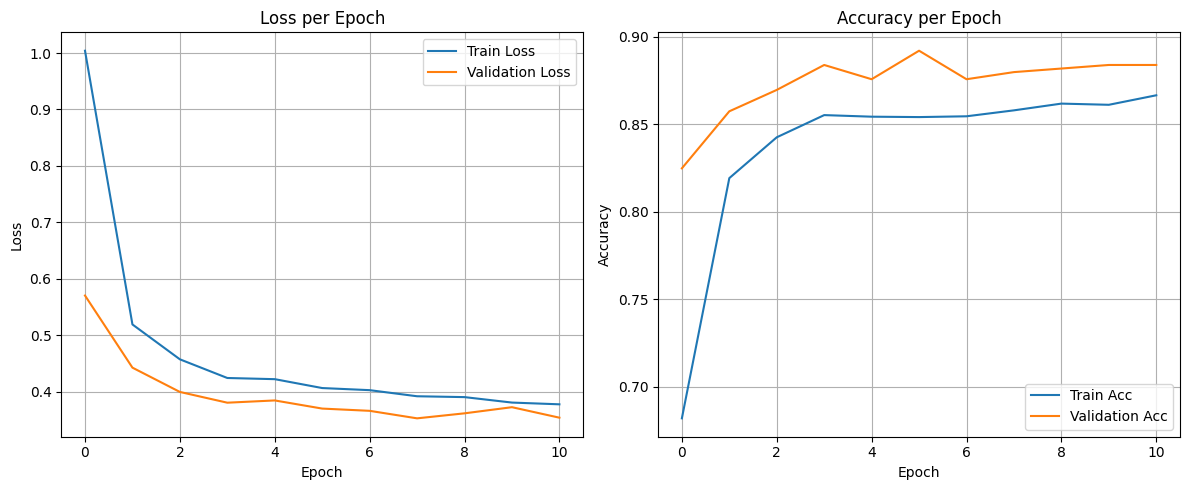

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



#모델 저장

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer.pt")

# 학습된 MLP 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())


# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8226 | F1-score: 0.8220
              precision    recall  f1-score   support

           0     0.8375    0.8171    0.8272       164
           1     0.6364    0.5676    0.6000        37
           2     0.5676    0.5250    0.5455        80
           3     0.9167    0.9105    0.9136       592
           4     0.7755    0.7950    0.7851       239
           5     0.7564    0.7284    0.7421        81
           6     0.7775    0.8118    0.7942       340

    accuracy                         0.8226      1533
   macro avg     0.7525    0.7365    0.7440      1533
weighted avg     0.8219    0.8226    0.8220      1533



# MLP 학습 - 2Layer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 7]           1,799
Total params: 1,051,143
Trainable params: 1,051,143
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.01
Estimated Total Size (MB): 4.03
----------------------------------------------------------------
Epoch 1 | Train Loss: 1.0029 | Train Acc: 0.6591 | Val Loss: 0.5970 | Val Acc: 0.8187
Epoch 2 | Train Loss: 0.5228 | Train Acc: 0.8138 | Val Loss: 0.4331 | Val Acc: 0

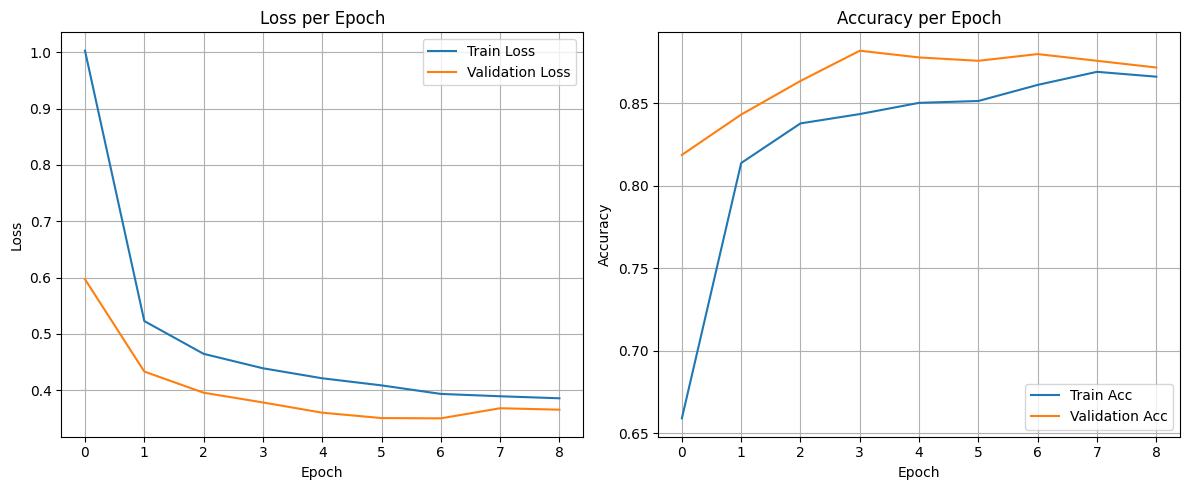

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)

# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_2Layer(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_2Layer().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




#모델 저장

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_2-Layer.pt")

# 학습된 MLP 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_2Layer(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_2Layer().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_2-Layer.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8056 | F1-score: 0.8035
              precision    recall  f1-score   support

           0     0.7430    0.8110    0.7755       164
           1     0.5455    0.4865    0.5143        37
           2     0.5156    0.4125    0.4583        80
           3     0.9097    0.9189    0.9143       592
           4     0.8424    0.7155    0.7738       239
           5     0.6854    0.7531    0.7176        81
           6     0.7493    0.8088    0.7779       340

    accuracy                         0.8056      1533
   macro avg     0.7130    0.7009    0.7045      1533
weighted avg     0.8046    0.8056    0.8035      1533



# MLP 학습 - 3Layer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,836,032
              ReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 7]             903
Total params: 2,427,399
Trainable params: 2,427,399
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 9.26
Estimated Total Size (MB): 9.30
---------------------------------------

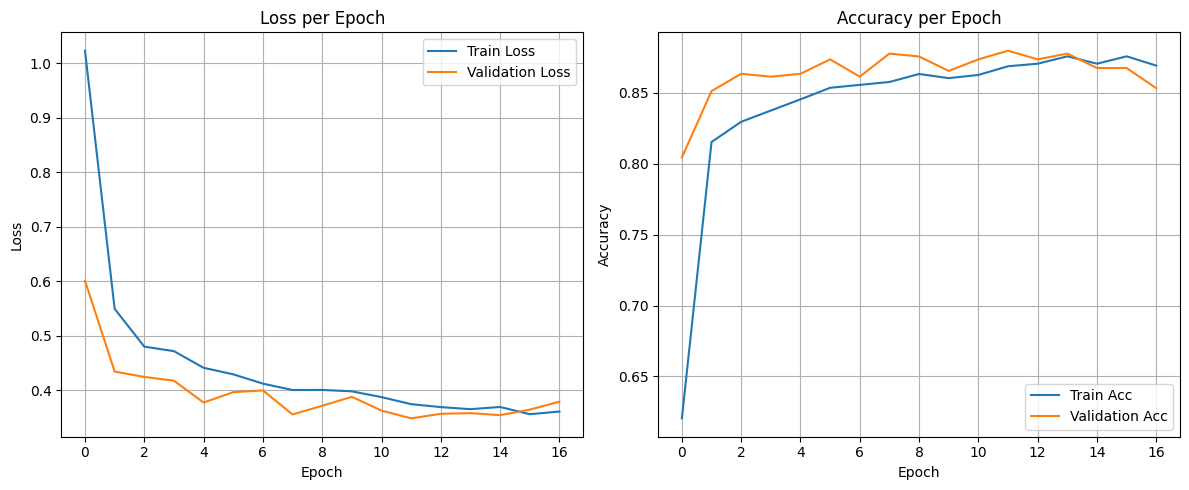

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_3Layer(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_3Layer().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#모델 저장

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_3-Layer.pt")

# 학습된 MLP 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_3Layer(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_3Layer().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_3-Layer.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))

✅ Test Accuracy: 0.8030 | F1-score: 0.8028
              precision    recall  f1-score   support

           0     0.7882    0.8171    0.8024       164
           1     0.6250    0.5405    0.5797        37
           2     0.4694    0.5750    0.5169        80
           3     0.8931    0.9172    0.9050       592
           4     0.8556    0.6444    0.7351       239
           5     0.7111    0.7901    0.7485        81
           6     0.7606    0.7941    0.7770       340

    accuracy                         0.8030      1533
   macro avg     0.7290    0.7255    0.7235      1533
weighted avg     0.8084    0.8030    0.8028      1533



# MLP 학습 - 1Layer + BN

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                    [-1, 7]           3,591
Total params: 922,631
Trainable params: 922,631
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.54
----------------------------------------------------------------
Epoch 1 | Train Loss: 0.5066 | Train Acc: 0.8251 | Val Loss: 0.4113 | Val Acc: 0.8656
Epoch 2 | Train Loss: 0.4091 | Train Acc: 0.8523 | Val Loss: 0.3812 | Val Acc: 0.8574
🛑 EarlyStopping counter: 1/5
Epoch 3 | Train Loss: 0.3847 | Tr

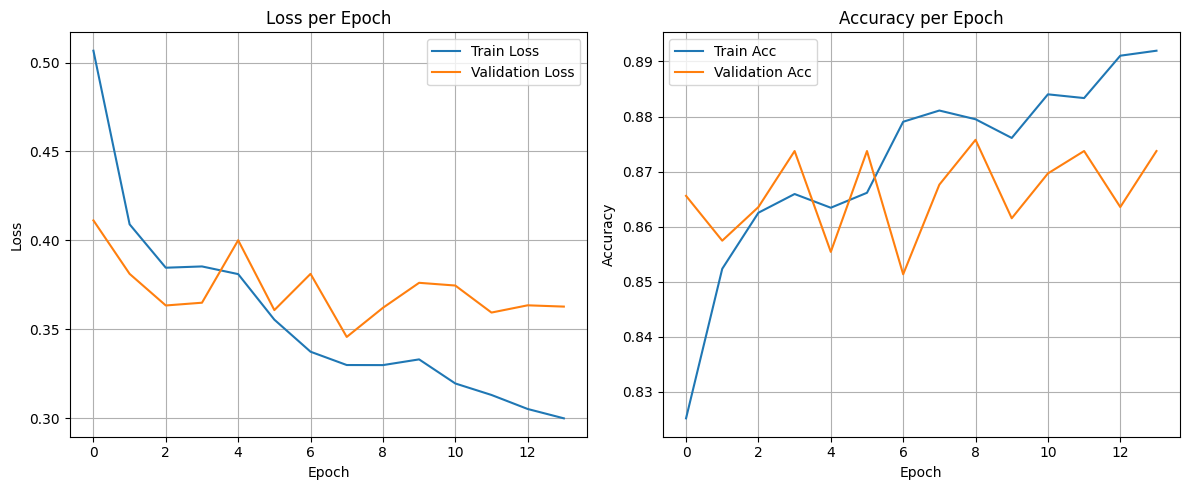

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_BN(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # ✅ BatchNorm 추가
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_BN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



#모델 저장

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_BN.pt")

# 학습된 MLP-BN 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_BN(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # ✅ BatchNorm 추가
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_BN().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_BD.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8180 | F1-score: 0.8171
              precision    recall  f1-score   support

           0     0.7965    0.8354    0.8155       164
           1     0.6562    0.5676    0.6087        37
           2     0.5902    0.4500    0.5106        80
           3     0.9311    0.8902    0.9102       592
           4     0.7810    0.7908    0.7859       239
           5     0.7143    0.8025    0.7558        81
           6     0.7561    0.8206    0.7870       340

    accuracy                         0.8180      1533
   macro avg     0.7465    0.7367    0.7391      1533
weighted avg     0.8186    0.8180    0.8171      1533



# MLP 학습 - 2Layer + BN

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
              ReLU-7                  [-1, 256]               0
            Linear-8                    [-1, 7]           1,799
Total params: 1,052,679
Trainable params: 1,052,679
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.02
Estimated Total Size (MB): 4.04
----------------------------------------------------------------
Epoch 1 | Train Loss: 0.5509 | Train A

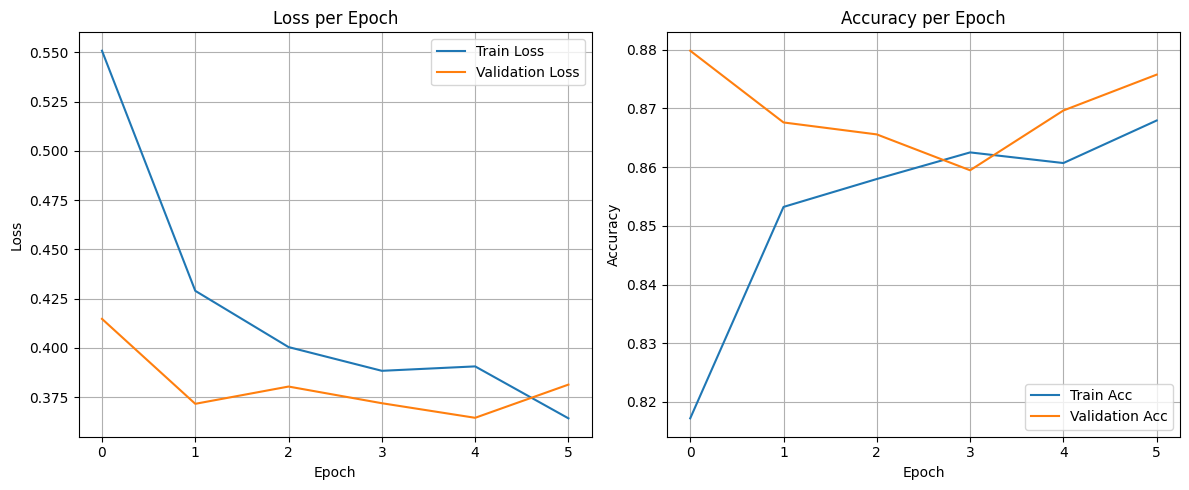

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_BN_2(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),       # ✅ BatchNorm1
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),       # ✅ BatchNorm2
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_BN_2().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



#모델 저장

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_2-Layer_BN.pt")

# 학습된 MLP-BN2 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_BN_2(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),       # ✅ BatchNorm1
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),       # ✅ BatchNorm2
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_BN_2().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_2-Layer_BN.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))

✅ Test Accuracy: 0.8076 | F1-score: 0.8026
              precision    recall  f1-score   support

           0     0.7824    0.8110    0.7964       164
           1     0.6190    0.3514    0.4483        37
           2     0.6071    0.4250    0.5000        80
           3     0.8873    0.9307    0.9085       592
           4     0.7911    0.7448    0.7672       239
           5     0.6702    0.7778    0.7200        81
           6     0.7688    0.7824    0.7755       340

    accuracy                         0.8076      1533
   macro avg     0.7323    0.6890    0.7023      1533
weighted avg     0.8022    0.8076    0.8026      1533



# MLP 학습 - 3Layer + BN

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,836,032
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
       BatchNorm1d-6                  [-1, 512]           1,024
              ReLU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
      BatchNorm1d-10                  [-1, 128]             256
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 7]             903
Total params: 2,430,727
Trainable params: 2,430,727
Non-trainable params: 0
---------------------------

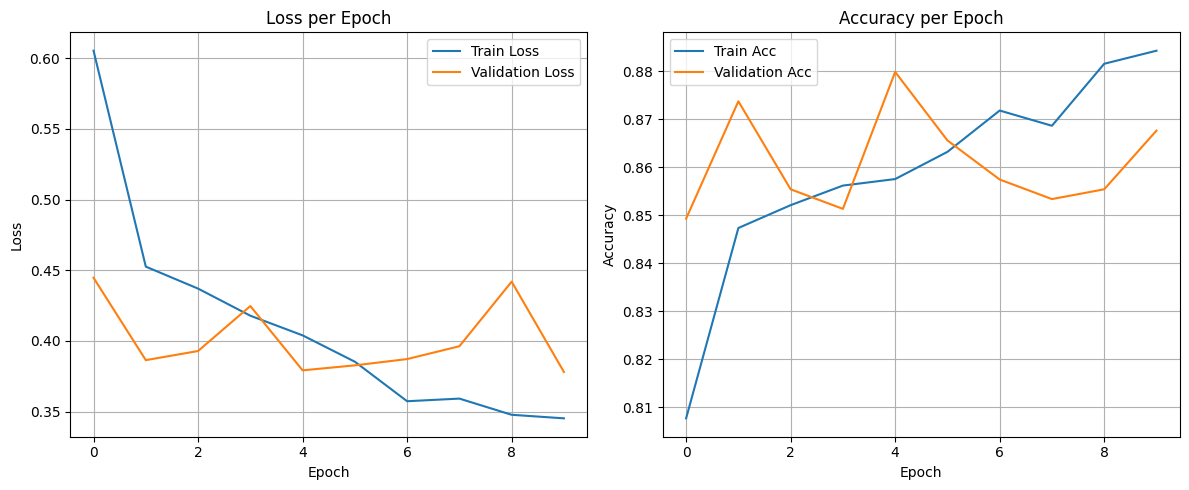

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)

# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_BN_3(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),     # 🔹 BatchNorm 1
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),      # 🔹 BatchNorm 2
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),      # 🔹 BatchNorm 3
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_BN_3().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#모델 학습

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_3-Layer_BN.pt")

# 학습된 MLP-BN3 모델 test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_BN_3(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),     # 🔹 BatchNorm 1
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),      # 🔹 BatchNorm 2
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),      # 🔹 BatchNorm 3
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_BN_3().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_3-Layer_BN.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8115 | F1-score: 0.8104
              precision    recall  f1-score   support

           0     0.7988    0.8232    0.8108       164
           1     0.6129    0.5135    0.5588        37
           2     0.5556    0.4375    0.4895        80
           3     0.9257    0.8834    0.9041       592
           4     0.7751    0.8075    0.7910       239
           5     0.7160    0.7160    0.7160        81
           6     0.7493    0.8265    0.7860       340

    accuracy                         0.8115      1533
   macro avg     0.7333    0.7154    0.7223      1533
weighted avg     0.8116    0.8115    0.8104      1533



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
         LeakyReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                    [-1, 7]           3,591
Total params: 921,607
Trainable params: 921,607
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.52
Estimated Total Size (MB): 3.53
----------------------------------------------------------------
Epoch 1 | Train Loss: 0.9472 | Train Acc: 0.6879 | Val Loss: 0.5099 | Val Acc: 0.8330
Epoch 2 | Train Loss: 0.4803 | Train Acc: 0.8324 | Val Loss: 0.4114 | Val Acc: 0.8676
Epoch 3 | Train Loss: 0.4332 | Train Acc: 0.8485 | Val Loss: 0.3815 | Val Acc: 0.8819
Epoch 4 | Train Loss: 0.4136 | Train Acc

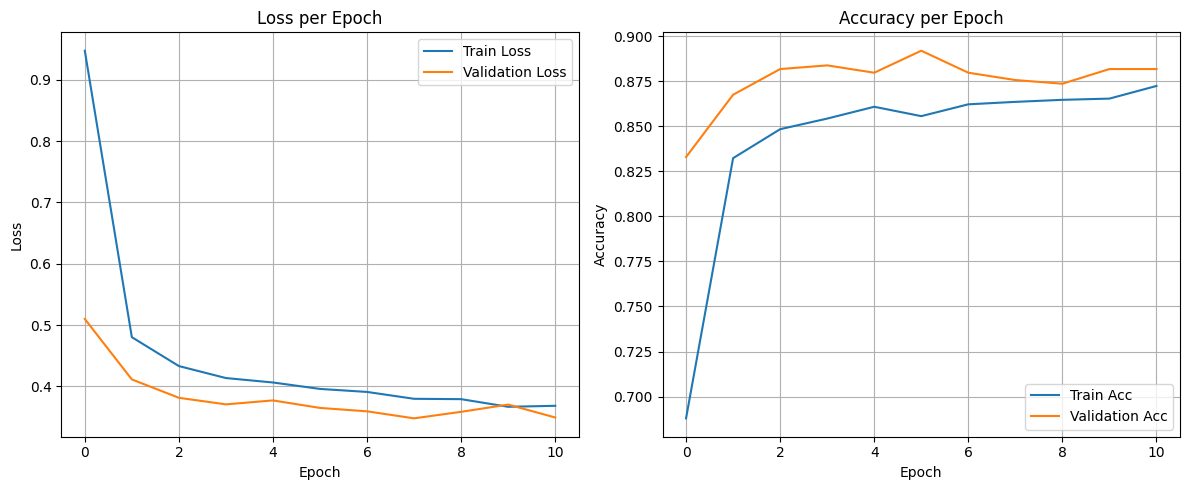

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_LL(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


# ✅ 모델, Loss, Optimizer
model = MLP_LL().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL.pt")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_LL(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=512, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_LL().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8213 | F1-score: 0.8205
              precision    recall  f1-score   support

           0     0.8313    0.8110    0.8210       164
           1     0.6562    0.5676    0.6087        37
           2     0.5556    0.5000    0.5263        80
           3     0.9181    0.9088    0.9134       592
           4     0.7680    0.8033    0.7853       239
           5     0.7692    0.7407    0.7547        81
           6     0.7746    0.8088    0.7914       340

    accuracy                         0.8213      1533
   macro avg     0.7533    0.7343    0.7430      1533
weighted avg     0.8205    0.8213    0.8205      1533



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         918,016
         LeakyReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 7]           1,799
Total params: 1,051,143
Trainable params: 1,051,143
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.01
Estimated Total Size (MB): 4.03
----------------------------------------------------------------
Epoch 1 | Train Loss: 0.9353 | Train Acc: 0.6809 | Val Loss: 0.5206 | Val Acc: 0.8371
Epoch 2 | Train Loss: 0.4841 | Train Acc: 0.8249 | Val Loss: 0.4177 | Val Acc: 0

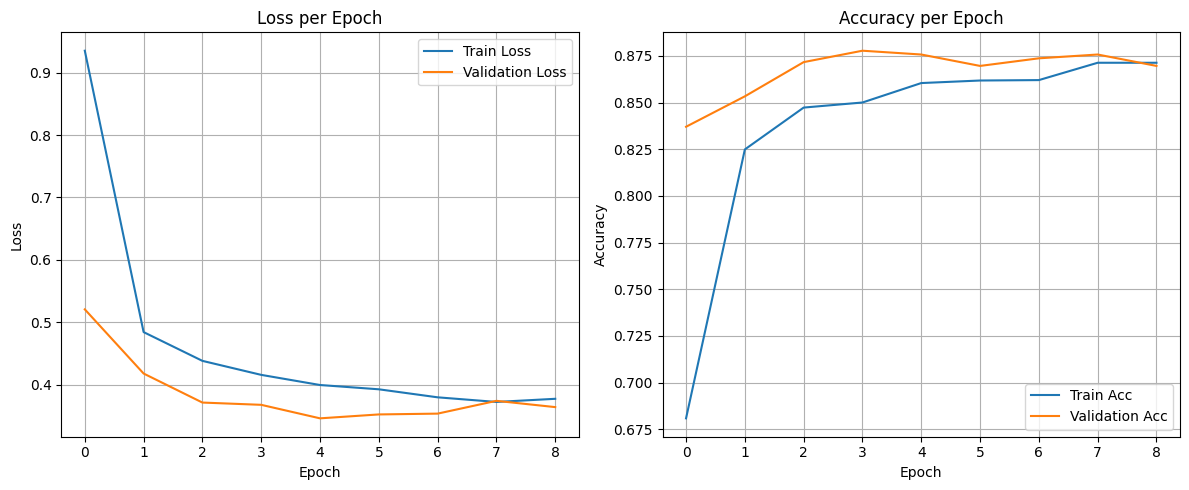

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)


X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_LL2(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.1),         # 🔁 ReLU → LeakyReLU
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),         # 🔁 ReLU → LeakyReLU
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_LL2().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL2.pt")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_LL2(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.1),         # 🔁 ReLU → LeakyReLU
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),         # 🔁 ReLU → LeakyReLU
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_LL2().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL2.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))

✅ Test Accuracy: 0.8128 | F1-score: 0.8100
              precision    recall  f1-score   support

           0     0.7630    0.8049    0.7834       164
           1     0.5789    0.5946    0.5867        37
           2     0.5849    0.3875    0.4662        80
           3     0.9098    0.9206    0.9152       592
           4     0.8429    0.7406    0.7884       239
           5     0.6813    0.7654    0.7209        81
           6     0.7507    0.8147    0.7814       340

    accuracy                         0.8128      1533
   macro avg     0.7302    0.7183    0.7203      1533
weighted avg     0.8114    0.8128    0.8100      1533



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,836,032
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 7]             903
Total params: 2,427,399
Trainable params: 2,427,399
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 9.26
Estimated Total Size (MB): 9.30
---------------------------------------

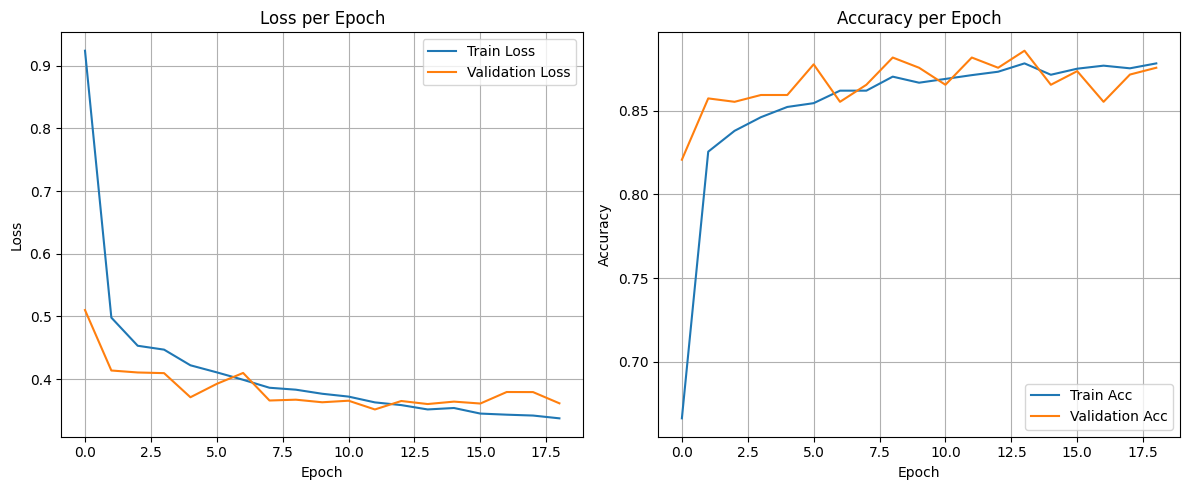

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  # ✅ 추가
from torchsummary import summary
import random

# ✅ Seed 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Seed 고정
set_seed(42)

# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 라벨 0부터 시작

# ✅ Train/Val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ MLP 모델 정의
class MLP_LL3(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.1),          # ✅ 1st activation
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),          # ✅ 2nd activation
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),          # ✅ 3rd activation
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 모델, Loss, Optimizer
model = MLP_LL3().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=5)
# ✅ summary 출력 (입력은 1D: 1792차원 벡터)
summary(model, input_size=(1792,))

# ✅ 그래프 저장용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ✅ 학습 루프
for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 📊 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Validation Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL3.pt")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# ✅ 1. MLP 모델 구조 정의 (동일해야 함)
class MLP_LL3(nn.Module):
    def __init__(self, input_dim=1792, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.1),          # ✅ 1st activation
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),          # ✅ 2nd activation
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),          # ✅ 3rd activation
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ✅ 2. 모델 로드
model = MLP_LL3().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/mlp_emotion_model_1-Layer_LL3.pt"))
model.eval()

# ✅ 3. 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨이 1~7이면 0~6으로 조정

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 4. 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8095 | F1-score: 0.8080
              precision    recall  f1-score   support

           0     0.8523    0.7744    0.8115       164
           1     0.5946    0.5946    0.5946        37
           2     0.5571    0.4875    0.5200        80
           3     0.9000    0.9274    0.9135       592
           4     0.7531    0.7531    0.7531       239
           5     0.7662    0.7284    0.7468        81
           6     0.7550    0.7794    0.7670       340

    accuracy                         0.8095      1533
   macro avg     0.7398    0.7207    0.7295      1533
weighted avg     0.8075    0.8095    0.8080      1533

